--- Step 0: Loading Detailed Data ---
Reading file...

--- Stage 1: Aggregating Customers (440 -> 100) ---

--- Stage 2: Generating Candidates (100 -> 50) ---

--- Stage 3: Snapping ---

Success! Files saved:
1. Aggregated_Customers_100.csv (Includes product-wise total demand)
2. Aggregated_Demand_Details.csv (Includes Product, Period detailed data - for model use)
3. Aggregated_Candidates_50_Snapped.csv (Final Warehouse Locations)


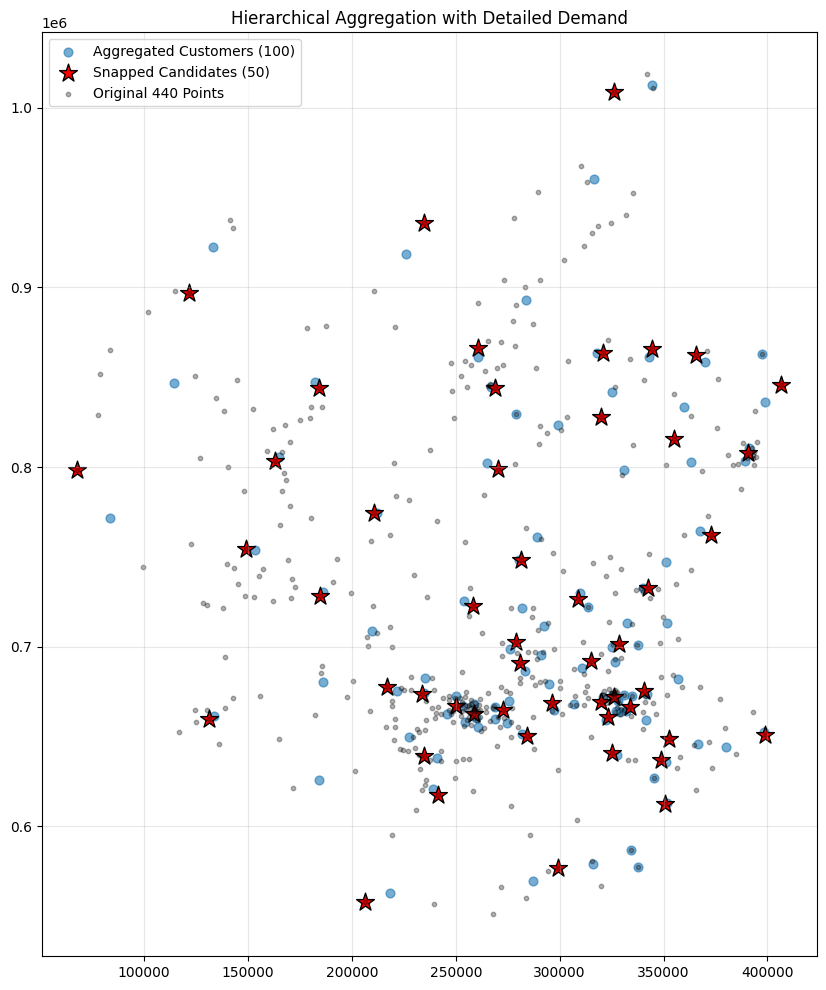

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ==========================================
# 1. Custom Weighted K-Means
# ==========================================
def weighted_kmeans_custom(X, weights, n_clusters, max_iter=100, tol=1e-4, random_state=42):
    n_samples, n_features = X.shape
    rng = np.random.RandomState(random_state)
    random_idx = rng.permutation(n_samples)[:n_clusters]
    centroids = X[random_idx]
    
    for iteration in range(max_iter):
        distances = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.zeros((n_clusters, n_features))
        for k in range(n_clusters):
            mask = (labels == k)
            if np.any(mask):
                new_centroids[k] = np.average(X[mask], axis=0, weights=weights[mask])
            else:
                new_centroids[k] = centroids[k]
        
        if np.sum((centroids - new_centroids)**2) < tol:
            break
        centroids = new_centroids
        
    return labels, centroids

# ==========================================
# 2. Data (Multi-Product and Time Dimensions)
# ==========================================
def parse_case_study_data_detailed(file_path):
    print("Reading file...")
    with open(file_path, 'r') as f:
        content = f.read()

    def get_vector(key, dtype=float):
        pattern = re.compile(rf"{key}:\s*\[(.*?)\]", re.DOTALL)
        match = pattern.search(content)
        if match:
            clean_str = match.group(1).replace('"', '').replace('\n', ' ')
            values = clean_str.split()
            if dtype == float: return [float(x) for x in values]
            elif dtype == str: return [str(x) for x in values]
            elif dtype == int: return [int(x) for x in values]
        return []

    ids = get_vector("CustomerId", str)
    easting = get_vector("CustomerEasting", float)
    northing = get_vector("CustomerNorthing", float)

    nb_customers = len(ids)
    
    # --- Key Modification: Store Detailed Demand Data ---
    # Structure: demand_details[original_cust_idx][product_idx 0-3][year_idx 0-9]
    # Assuming max 4 products, 10 years
    demand_details = np.zeros((nb_customers, 4, 10)) 
    total_demands = np.zeros(nb_customers) # Total demand is still needed as clustering weight
    
    start_marker = "CustomerDemandPeriods: ["
    start_idx = content.find(start_marker)
    if start_idx != -1:
        # Regex matches (Cust, Prod, Scen) and the following 10 numbers
        pattern = re.compile(r"\((\d+)\s+(\d+)\s+(\d+)\)\s+([\d\s]+)")
        matches = pattern.finditer(content, start_idx)
        for match in matches:
            c_id = int(match.group(1)) - 1 # 0-based index
            p_id = int(match.group(2))     # Product ID (usually 1-4)
            s_id = int(match.group(3))     # Scenario ID
            
            # We only take Scenario 1
            if s_id == 1 and 1 <= p_id <= 4: 
                vals = [float(x) for x in match.group(4).split()]
                # Store detailed data
                for t in range(len(vals)):
                    if t < 10:
                        demand_details[c_id, p_id-1, t] = vals[t]
                
                # Accumulate to total weight for this customer
                total_demands[c_id] += sum(vals)

    df = pd.DataFrame({
        'Original_ID': ids,
        'Easting': easting,
        'Northing': northing,
        'Total_Demand': total_demands
    })
    
    # Prevent zero weight
    df.loc[df['Total_Demand'] == 0, 'Total_Demand'] = 1.0
    
    return df, demand_details

# ==========================================
# 3. Main
# ==========================================
if __name__ == "__main__":
    file_name = 'CaseStudyData.txt'
    
    N_CUSTOMERS_AGG = 100   # Stage 1
    N_CANDIDATES_AGG = 50   # Stage 2
    
    try:
        # Step 0: Load Data
        print("--- Step 0: Loading Detailed Data ---")
        df_raw, demand_matrix = parse_case_study_data_detailed(file_name)
        # demand_matrix shape: (440, 4, 10)
        
        # Step 1: Cluster Customers (440 -> 100)
        print(f"\n--- Stage 1: Aggregating Customers (440 -> {N_CUSTOMERS_AGG}) ---")
        X_raw = df_raw[['Easting', 'Northing']].values
        W_raw = df_raw['Total_Demand'].values
        labels_1, centroids_1 = weighted_kmeans_custom(X_raw, W_raw, n_clusters=N_CUSTOMERS_AGG)
        
        # --- Aggregate Detailed Demand ---
        stage1_data = []      # To save coordinates and total demand for 100 points
        detailed_demand_rows = [] # To save long-format table (ID, Prod, Year, Demand)
        
        for i in range(N_CUSTOMERS_AGG):
            # Find all original customers belonging to this new Cluster i
            mask = (labels_1 == i)
            original_indices = np.where(mask)[0]
            
            # 1. Calculate total demand weight for this Cluster
            total_demand = W_raw[mask].sum()
            
            # 2. Calculate detailed demand by Product and Year
            # Shape change: (Num_Members, 4, 10) -> sum axis 0 -> (4, 10)
            cluster_demand_matrix = demand_matrix[original_indices].sum(axis=0)
            
            # 3. Prepare data row for Aggregated_Customers_100.csv
            row_data = {
                'Agg_Cust_ID': i,
                'Easting': centroids_1[i][0],
                'Northing': centroids_1[i][1],
                'Total_Demand_All_Years': total_demand
            }
            # Add product-wise totals (for quick overview)
            for p in range(4):
                row_data[f'Demand_P{p+1}_Total'] = cluster_demand_matrix[p, :].sum()
            stage1_data.append(row_data)
            
            # 4. Prepare data row for Aggregated_Demand_Details.csv (for optimization model)
            for p in range(4):
                for t in range(10):
                    detailed_demand_rows.append({
                        'Customer': i,        # New Aggregated Customer ID
                        'Product': p + 1,
                        'Period': t + 1,
                        'Demand': cluster_demand_matrix[p, t]
                    })
        
        df_stage1 = pd.DataFrame(stage1_data)
        df_details = pd.DataFrame(detailed_demand_rows)
        
        # Step 2: Cluster Candidates (100 -> 50)
        print(f"\n--- Stage 2: Generating Candidates ({N_CUSTOMERS_AGG} -> {N_CANDIDATES_AGG}) ---")
        X_stage1 = df_stage1[['Easting', 'Northing']].values
        W_stage1 = df_stage1['Total_Demand_All_Years'].values
        labels_2, centroids_2 = weighted_kmeans_custom(X_stage1, W_stage1, n_clusters=N_CANDIDATES_AGG)
        
        # Step 3: Snapping
        print("\n--- Stage 3: Snapping ---")
        candidates_final = []
        for c_id in range(N_CANDIDATES_AGG):
            theo_x = centroids_2[c_id][0]
            theo_y = centroids_2[c_id][1]
            distances = np.sqrt((df_raw['Easting'] - theo_x)**2 + (df_raw['Northing'] - theo_y)**2)
            nearest_idx = distances.idxmin()
            
            candidates_final.append({
                'Candidate_ID': c_id,
                'Snapped_Original_ID': df_raw.loc[nearest_idx, 'Original_ID'],
                'New_Easting': df_raw.loc[nearest_idx, 'Easting'],
                'New_Northing': df_raw.loc[nearest_idx, 'Northing']
            })
        df_candidates_final = pd.DataFrame(candidates_final)
        
        # =========================================================
        # Save Files
        # =========================================================
        # 1. Aggregated Customer Points (Includes coordinates + 4 products total demand)
        df_stage1.to_csv('Aggregated_Customers_100.csv', index=False)
        
        # 2. Detailed Demand Table (Used for Optimization Model)
        df_details.to_csv('Aggregated_Demand_Details.csv', index=False)
        
        # 3. Final 50 Warehouse Candidate Points
        df_candidates_final.to_csv('Aggregated_Candidates_50_Snapped.csv', index=False)
        
        print("\nSuccess! Files saved:")
        print("1. Aggregated_Customers_100.csv (Includes product-wise total demand)")
        print("2. Aggregated_Demand_Details.csv (Includes Product, Period detailed data - for model use)")
        print("3. Aggregated_Candidates_50_Snapped.csv (Final Warehouse Locations)")
        
        # Plotting (Unchanged)
        plt.figure(figsize=(10, 12))
        plt.scatter(df_stage1['Easting'], df_stage1['Northing'], 
                   c='tab:blue', s=40, alpha=0.6, label='Aggregated Customers (100)')
        plt.scatter(df_candidates_final['New_Easting'], df_candidates_final['New_Northing'], 
                   c='red', marker='*', s=180, edgecolors='black', label='Snapped Candidates (50)')
        plt.scatter(df_raw['Easting'], df_raw['Northing'], 
                   c='black', s=10, alpha=0.3, label='Original 440 Points')
        plt.title('Hierarchical Aggregation with Detailed Demand')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    except FileNotFoundError:
        print(f"Error: Could not find {file_name}")